# Using ChoiceRank to understand network traffic

This notebook provides a quick example on how to use ChoiceRank to estimate transitions along the edges of a network based only on the marginal traffic at the nodes.

In [1]:
import choix
import networkx as nx
import numpy as np

%matplotlib inline

## 1. Generating sample data

First, we will generate sample data.
This includes

1. generating a network,
2. generating a parameter for each node of the network,
3. generating samples of choices in the network.

In [2]:
n_items = 8
p_edge = 0.3
n_samples = 3000

# 1. Generate a network.
graph = nx.erdos_renyi_graph(n_items, p_edge, directed=True)

# 2. Generate a parameter for each node.
params = choix.generate_params(n_items, interval=2.0)

# 3. Generate samples of choices in the network.
transitions = np.zeros((n_items, n_items))
for _ in range(n_samples):
    src = np.random.choice(n_items)
    neighbors = graph.successors(src)
    if len(neighbors) == 0:
        continue
    dst = choix.compare(neighbors, params)
    transitions[src, dst] += 1

The network looks as follows

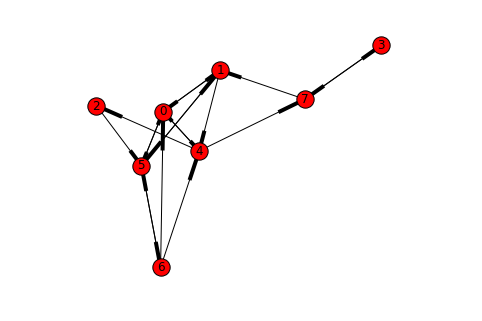

In [3]:
nx.draw(graph, with_labels=True)

Now we aggregate the all the transitions into *incoming traffic* and *outgoing traffic*.

In [4]:
traffic_in = transitions.sum(axis=0)
traffic_out = transitions.sum(axis=1)

print("incoming traffic:", traffic_in)
print("outgoing traffic:", traffic_out)

incoming traffic: [ 465.  682.  155.   83.  369.  593.  148.  505.]
outgoing traffic: [ 397.  367.  365.  359.  384.  399.  365.  364.]


## 2. Estimating transitions using ChoiceRank

ChoiceRank can be used to recover the transitions on the network based only on:

1. information about the structure of the network, and
2. the (marginal) incoming and outgoing traffic at each node.

ChoiceRank works under the assumption that each node has a latent "preference" score, and that transitions follow Luce's choice model.

In [5]:
params = choix.choicerank(graph, traffic_in, traffic_out)

We can attempt to reconstruct the transition matrix using the marginal traffic data and the parameters.

In [6]:
est = np.zeros((n_items, n_items))
for src in range(n_items):
    neighbors = graph.successors(src)
    if len(neighbors) == 0:
        continue
    probs = choix.probabilities(neighbors, params)
    est[src,neighbors] = traffic_out[src] * probs

In [7]:
print("True transition matrix:")
print(transitions)

print("\nEstimated transition matrix:")
print(np.round_(est))

print("\nDifference:")
print(np.round_(transitions - est))

True transition matrix:
[[   0.  233.    0.    0.   94.   70.    0.    0.]
 [ 148.    0.    0.    0.  143.   76.    0.    0.]
 [   0.    0.    0.    0.    0.  365.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  359.]
 [  83.    0.  155.    0.    0.    0.    0.  146.]
 [  83.  168.    0.    0.    0.    0.  148.    0.]
 [ 151.    0.    0.    0.  132.   82.    0.    0.]
 [   0.  281.    0.   83.    0.    0.    0.    0.]]

Estimated transition matrix:
[[   0.  232.    0.    0.  102.   63.    0.    0.]
 [ 150.    0.    0.    0.  134.   83.    0.    0.]
 [   0.    0.    0.    0.    0.  365.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  359.]
 [  84.    0.  155.    0.    0.    0.    0.  146.]
 [  83.  169.    0.    0.    0.    0.  148.    0.]
 [ 149.    0.    0.    0.  133.   83.    0.    0.]
 [   0.  280.    0.   84.    0.    0.    0.    0.]]

Difference:
[[ 0.  1.  0.  0. -8.  7.  0.  0.]
 [-2.  0.  0.  0.  9. -7.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 